In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
data = yf.download('0005.hk')
data.drop("Adj Close",axis=1,inplace=True)
data.tail(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2021-12-06,44.500000,44.950001,44.250000,44.849998,21997237
2021-12-07,44.799999,45.750000,44.400002,45.650002,15839694
2021-12-08,45.950001,45.950001,45.099998,45.500000,8590654
2021-12-09,45.450001,45.900002,45.150002,45.299999,6908033
2021-12-10,45.099998,45.400002,44.950001,45.200001,6090109
2021-12-13,45.200001,45.250000,44.500000,45.099998,10861423
2021-12-14,44.150002,44.599998,44.150002,44.500000,7998591
2021-12-15,44.700001,45.400002,44.450001,44.950001,11227978
2021-12-16,44.849998,45.150002,44.299999,45.150002,9989350


In [3]:
df = data
#Create one more column Prediction shifted 15 days up.
df['Prediction'] = data[['Close']].shift(-1)
#print data set
df=df.dropna()
print(df)

                  Open        High         Low       Close    Volume  \
Date                                                                   
2000-01-03  111.000000  111.500000  107.500000  108.000000   3908164   
2000-01-04  106.000000  106.500000  105.000000  106.000000   6895378   
2000-01-05  101.000000  102.000000   99.500000  100.500000  14657098   
2000-01-06  101.000000  102.000000   96.250000   97.000000  10632084   
2000-01-07   98.500000  101.000000   97.500000  100.500000   8368286   
...                ...         ...         ...         ...       ...   
2021-12-17   46.299999   46.750000   46.049999   46.400002  39799001   
2021-12-20   45.799999   46.000000   45.349998   45.500000  16771986   
2021-12-21   45.700001   45.750000   45.200001   45.450001  12301373   
2021-12-22   45.599998   45.750000   45.299999   45.700001   8541568   
2021-12-23   46.299999   46.299999   45.900002   46.200001   9198207   

            Prediction  
Date                    
2000-01-03  1

In [4]:
#Create a data set X and convert it into numpy array , which will be having actual values
X = np.array(df.drop(['Prediction'],1))
#Remove the last 15 rows
X_unseen=X[-15:]
X = X[:-15]
print(X)
# Create a dataset y which will be having Predicted values and convert into numpy array
y = np.array(df['Prediction'])
# Remove Last 15 rows
y_unseen=y[-15:]
y = y[:-15]
print(y)

[[1.11000000e+02 1.11500000e+02 1.07500000e+02 1.08000000e+02
  3.90816400e+06]
 [1.06000000e+02 1.06500000e+02 1.05000000e+02 1.06000000e+02
  6.89537800e+06]
 [1.01000000e+02 1.02000000e+02 9.95000000e+01 1.00500000e+02
  1.46570980e+07]
 ...
 [4.37000008e+01 4.37999992e+01 4.22000008e+01 4.29500008e+01
  2.38784420e+07]
 [4.32999992e+01 4.38499985e+01 4.30000000e+01 4.35000000e+01
  1.55167360e+07]
 [4.36500015e+01 4.44500008e+01 4.35000000e+01 4.40000000e+01
  1.47136920e+07]]
[106.         100.5         97.         ...  43.5         44.
  44.84999847]


In [5]:
# Split the data into train and test with 90 & 10 % respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train=X_train.reshape(X_train.shape[0],1,5)
X_test=X_test.reshape(X_test.shape[0],1,5)

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(5, input_shape= (X_train.shape[1], X_train.shape[2])))
# model.add(Dense(1))
model.add(Dense(1))
model.compile(
    loss="mean_squared_error",
    optimizer='Adam'
)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 220       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 226
Trainable params: 226
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Fit model with history to check for overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0)
history = model.fit(X_train,y_train,epochs=600,batch_size=10,validation_data=(X_test,y_test),shuffle=False,verbose=1)

Epoch 1/600
438/438 [==============================] - 10s 2ms/step - loss: 8255.7832 - val_loss: 8505.7373
Epoch 2/600
438/438 [==============================] - 1s 1ms/step - loss: 8180.7522 - val_loss: 8430.2373
Epoch 3/600
438/438 [==============================] - 1s 1ms/step - loss: 8105.8898 - val_loss: 8352.9346
Epoch 4/600
438/438 [==============================] - 1s 1ms/step - loss: 8030.5130 - val_loss: 8278.0801
Epoch 5/600
438/438 [==============================] - 1s 1ms/step - loss: 7956.7644 - val_loss: 8203.7598
Epoch 6/600
438/438 [==============================] - 1s 1ms/step - loss: 7883.5232 - val_loss: 8129.9150
Epoch 7/600
438/438 [==============================] - 1s 1ms/step - loss: 7810.7388 - val_loss: 8056.5171
Epoch 8/600
438/438 [==============================] - 1s 1ms/step - loss: 7738.3923 - val_loss: 7983.5464
Epoch 9/600
438/438 [==============================] - 1s 1ms/step - loss: 7666.4698 - val_loss: 7910.9937
Epoch 10/600
438/438 [==============

Epoch 77/600
438/438 [==============================] - 1s 1ms/step - loss: 3668.1000 - val_loss: 3867.6711
Epoch 78/600
438/438 [==============================] - 1s 1ms/step - loss: 3622.4741 - val_loss: 3821.4441
Epoch 79/600
438/438 [==============================] - 1s 1ms/step - loss: 3577.2295 - val_loss: 3775.6033
Epoch 80/600
438/438 [==============================] - 1s 1ms/step - loss: 3532.3647 - val_loss: 3730.1421
Epoch 81/600
438/438 [==============================] - 1s 1ms/step - loss: 3487.8800 - val_loss: 3685.0640
Epoch 82/600
438/438 [==============================] - 1s 1ms/step - loss: 3443.7768 - val_loss: 3640.3655
Epoch 83/600
438/438 [==============================] - 1s 1ms/step - loss: 3400.0513 - val_loss: 3596.0483
Epoch 84/600
438/438 [==============================] - 1s 1ms/step - loss: 3356.7053 - val_loss: 3552.1135
Epoch 85/600
438/438 [==============================] - 1s 1ms/step - loss: 3313.7387 - val_loss: 3508.5640
Epoch 86/600
438/438 [======

438/438 [==============================] - 1s 1ms/step - loss: 1292.4992 - val_loss: 1451.8356
Epoch 153/600
438/438 [==============================] - 1s 1ms/step - loss: 1274.9418 - val_loss: 1433.7847
Epoch 154/600
438/438 [==============================] - 1s 1ms/step - loss: 1257.6845 - val_loss: 1416.0771
Epoch 155/600
438/438 [==============================] - 1s 1ms/step - loss: 1240.8075 - val_loss: 1398.7180
Epoch 156/600
438/438 [==============================] - 1s 1ms/step - loss: 1224.3232 - val_loss: 1381.7521
Epoch 157/600
438/438 [==============================] - 1s 1ms/step - loss: 1208.1831 - val_loss: 1364.9690
Epoch 158/600
438/438 [==============================] - 1s 1ms/step - loss: 1192.4591 - val_loss: 1349.0625
Epoch 159/600
438/438 [==============================] - 1s 1ms/step - loss: 1176.8484 - val_loss: 1332.7502
Epoch 160/600
438/438 [==============================] - 0s 1ms/step - loss: 1161.9186 - val_loss: 1317.7244
Epoch 161/600
438/438 [==========

438/438 [==============================] - 1s 1ms/step - loss: 783.1449 - val_loss: 916.6271
Epoch 229/600
438/438 [==============================] - 1s 1ms/step - loss: 782.6681 - val_loss: 916.2350
Epoch 230/600
438/438 [==============================] - 1s 1ms/step - loss: 782.3385 - val_loss: 916.2503
Epoch 231/600
438/438 [==============================] - 1s 1ms/step - loss: 782.1668 - val_loss: 915.2723
Epoch 232/600
438/438 [==============================] - 1s 1ms/step - loss: 781.7739 - val_loss: 915.2043
Epoch 233/600
438/438 [==============================] - 1s 1ms/step - loss: 781.5926 - val_loss: 915.4092
Epoch 234/600
438/438 [==============================] - 1s 1ms/step - loss: 781.4726 - val_loss: 915.2301
Epoch 235/600
438/438 [==============================] - 1s 1ms/step - loss: 781.3322 - val_loss: 915.0797
Epoch 236/600
438/438 [==============================] - 1s 1ms/step - loss: 781.2174 - val_loss: 914.2638
Epoch 237/600
438/438 [============================

438/438 [==============================] - 1s 1ms/step - loss: 778.8139 - val_loss: 910.1702
Epoch 305/600
438/438 [==============================] - 1s 1ms/step - loss: 778.8091 - val_loss: 910.1565
Epoch 306/600
438/438 [==============================] - 1s 1ms/step - loss: 778.8046 - val_loss: 910.1425
Epoch 307/600
438/438 [==============================] - 1s 1ms/step - loss: 778.7998 - val_loss: 910.1286
Epoch 308/600
438/438 [==============================] - 1s 1ms/step - loss: 778.7949 - val_loss: 910.1149
Epoch 309/600
438/438 [==============================] - 1s 1ms/step - loss: 778.7905 - val_loss: 910.1017
Epoch 310/600
438/438 [==============================] - 1s 1ms/step - loss: 778.7858 - val_loss: 910.0888
Epoch 311/600
438/438 [==============================] - 1s 1ms/step - loss: 778.7816 - val_loss: 910.0765
Epoch 312/600
438/438 [==============================] - 1s 1ms/step - loss: 778.7773 - val_loss: 910.0642
Epoch 313/600
438/438 [============================

438/438 [==============================] - 1s 1ms/step - loss: 778.1154 - val_loss: 907.9670
Epoch 381/600
438/438 [==============================] - 1s 1ms/step - loss: 778.1121 - val_loss: 907.9586
Epoch 382/600
438/438 [==============================] - 1s 1ms/step - loss: 778.1090 - val_loss: 907.9499
Epoch 383/600
438/438 [==============================] - 1s 1ms/step - loss: 778.1056 - val_loss: 907.9410
Epoch 384/600
438/438 [==============================] - 1s 1ms/step - loss: 778.1025 - val_loss: 907.9330
Epoch 385/600
438/438 [==============================] - 1s 1ms/step - loss: 778.0993 - val_loss: 907.9246
Epoch 386/600
438/438 [==============================] - 1s 1ms/step - loss: 778.0961 - val_loss: 907.9161
Epoch 387/600
438/438 [==============================] - 1s 1ms/step - loss: 778.0928 - val_loss: 907.9079
Epoch 388/600
438/438 [==============================] - 1s 1ms/step - loss: 778.0897 - val_loss: 907.8994
Epoch 389/600
438/438 [============================

438/438 [==============================] - 1s 1ms/step - loss: 777.8893 - val_loss: 907.4222
Epoch 457/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8866 - val_loss: 907.4156
Epoch 458/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8839 - val_loss: 907.4093
Epoch 459/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8813 - val_loss: 907.4026
Epoch 460/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8786 - val_loss: 907.3963
Epoch 461/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8758 - val_loss: 907.3900
Epoch 462/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8728 - val_loss: 907.3833
Epoch 463/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8702 - val_loss: 907.3768
Epoch 464/600
438/438 [==============================] - 1s 1ms/step - loss: 777.8675 - val_loss: 907.3704
Epoch 465/600
438/438 [============================

438/438 [==============================] - 1s 1ms/step - loss: 777.7033 - val_loss: 906.9435
Epoch 533/600
438/438 [==============================] - 1s 1ms/step - loss: 777.7013 - val_loss: 906.9374
Epoch 534/600
438/438 [==============================] - 0s 1ms/step - loss: 777.6992 - val_loss: 906.9316
Epoch 535/600
438/438 [==============================] - 0s 1ms/step - loss: 777.6970 - val_loss: 906.9255
Epoch 536/600
438/438 [==============================] - 1s 1ms/step - loss: 777.6950 - val_loss: 906.9197
Epoch 537/600
438/438 [==============================] - 1s 1ms/step - loss: 777.6927 - val_loss: 906.9135
Epoch 538/600
438/438 [==============================] - 1s 1ms/step - loss: 777.6906 - val_loss: 906.9074
Epoch 539/600
438/438 [==============================] - 1s 1ms/step - loss: 777.6886 - val_loss: 906.9012
Epoch 540/600
438/438 [==============================] - 1s 1ms/step - loss: 777.6865 - val_loss: 906.8950
Epoch 541/600
438/438 [============================

In [9]:
y_pred=model.predict(X_test)

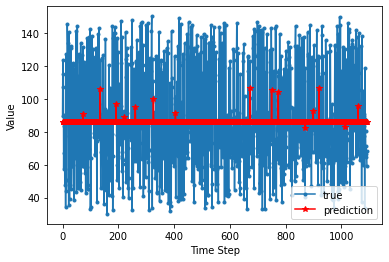

In [10]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();